# Fine-Tuning an LLM for Philosophy

By: Shravya Chepa

**Goal**: Fine-tune a model to write philosophical queries and receive responses focusing on various schools of thought like: Stoicism, Nihilism, Rationalism, Existentialism, Utilitarianism, Buddhism, Hinduism, Taoism, and Hedonism.

## *Installs*
The following modules need to be installed:
```pip install bitsandbytes 'accelerate>=0.26.0' peft datasets torch```

## *Process*

### 1. Dataset Preparation and Formatting: 
Gather texts from Stoicism, Hinduism, Taoism, and other schools of philosophy that are in the public domain. Make sure the books are public domain and free to use. The following books were used for this purpose:
- [Letters from a Stoic by Seneca (Stoicism)](https://archive.org/details/letters-from-a-stoic-1)
- [Beyond Good and Evil by Friedrich Nietzsche (Nihilism)](https://archive.org/details/beyondgoodandevi00nietuoft)
- [Ethics by Spinoza (Rationalism)](https://archive.org/details/in.ernet.dli.2015.263056)
- [Fear and Trembling and The Sickness Unto Death by Søren Kierkegaard (Existentialism)](https://archive.org/details/fear-and-trembling-and-the-sickness-unto-death)
- [Utilitarianism by John Stuart Mill (Utilitarianism)](https://archive.org/details/utilitarianism00millrich)
- [The Sacred Books of the East edited by Max Muller (Buddhism)](https://www.gutenberg.org/ebooks/2017)
- [The Song Celestial by Sir Edwin Arnold (Hinduism)](https://archive.org/details/FoZf_the-song-celestial-bhagavad-gita-by-sir-edwin-arnold-jaico-publishing-house)
- [Tao Te Ching by Laozi (Taoism)](https://archive.org/details/laozi_tao-te-ching)
- [On the Nature of Things by Lucretius (Hedonism)](https://archive.org/details/lucretiusonnatu00lucr)

Convert text into prompts and responses format. Use a semi-automated approach to generate these pairs. Use GPT o4 to generate these pairs from the books. Then structure the dataset in a consistent instruction-response format. Each data point is a JSON object with "instruction" field, an "input" field, and an "output" field. Since we need simple Q&A, the "input" is an empty string and "output" is the answer.

```
{
    "instruction": "What Stoic advice is given for dealing with life’s hardships such as poverty and death?",
    "input": "",
    "output": "Stoicism advises that each day, one should reflect on a single, meaningful idea that strengthens the mind against hardship. By regularly contemplating themes like poverty and mortality, one builds resilience and learns to face such conditions with calm acceptance."
}
```

Store the dataset in the data folder. There are two datasets that I experimented with: main_data.json (1035 objects) and expanded_data.json (2129 objects). These only differ in the number of examples I used for training.

### 2. Model Selection (Choosing a Base LLM):
I chose Phi-2 model because it is known for its strong performance despite its small-scale size. This model is then fine-tuned using LoRA.

### 3. Fine-Tuning Methodology:
Utilize supervised instruction tuning with parameter-efficient fine-tuning (PEFT) via Low-Rank Adaptation (LoRA). LoRA tunes only a small percentage of the model's weights by inserting low-rank adapters, instead of updating all the billions of parameters. Can also combine LoRA with 4-bit quantization (QLoRA). The modules transformers, peft and bitsandbytes are used for this purpose. 
- Environment setup.
- Load the base model and tokenizer with 4-bit precision loading enabled.
- Prepare LoRA adapters (prepare_model_for_kbit_training).
- Prepare the data for training. Tokenize the prompts and responses for the model. Format the instruction-response pairs so that only the response tokens contribute to the loss, by masking the prompt tokens during training (InstructionResponseCollator class defined).
Alpaca format style looks like the following:
```
### Instruction: [instruction text]
### Response: [response text]
```
- Set the training hyperparameters and run the training loop.

### 4. Use the Fine-Tuned Model
Once the training is complete, the model's LoRA adapter weights are saved within a folder. These weights can be loaded on top of the base model using PEFT library. I have three folders containing weights of three different models.
- philosophy_model0: This contains the weights of the training when I did not specify EOS (End of Sequence) token to every response during training so the model did not learn when to end the response. So I fixed that for subsequent training and tests.
- philosophy_model: This contains the weights of the training with the original dataset of 1035 entries. I found this model to be very overfit and wanted to improve performance against new unseen queries.
- philosophy_model2: This contains the weights after training on an expanded dataset with a 1000 more question-answer pairs.

### 5. Test Models with Prompts
Test the base model, model1 (1035 entries) and model2 (2129 entries) with new random questions.

### 6. Visualize Training Loss Curve
Read the training log from trainer_state.json and extract loss at each logging step. Then plot a line chart showing how the training loss decreases over time, visualizing the model's convergence.

### 7. Evaluation
Evaluate the model's answers. For this purpose, since the answers are open-ended, use GPT o3 to evaluate correctness, coherence and alignment to the specific philosophy of the responses.
Create new set of questions and compare the results from base model and the fine-tuned model.

### 8. Hugging Face Upload and Demo Application
Upload the model weights to Hugging Face and create a sample application to interact with the LLM model:
[https://huggingface.co/spaces/shravya-chepa/phi2-philosophy](https://huggingface.co/spaces/shravya-chepa/phi2-philosophy)

## *Hardware Used*
The experiments were conducted on an **NVIDIA A100 80GB PCIe GPU** with **CUDA 12.4** and **driver version 550.127.05**. MIG (Multi-Instance GPU) mode was **enabled**, with one instance active during testing.


## *References*

The following resources were used extensively to come up with strategy and to implement instruction fine tuning on open source LLMs.

- Raschka, S. (2023). *Build a large language model (from scratch)* [Book]. [https://learning.oreilly.com/library/view/build-a-large/9781633437166/](https://learning.oreilly.com/library/view/build-a-large/9781633437166/)

- Raschka, S. (n.d.). *Build a large language model (from scratch)* [Video series]. YouTube. [https://youtube.com/playlist?list=PLTKMiZHVd_2IIEsoJrWACkIxLRdfMlw11](https://youtube.com/playlist?list=PLTKMiZHVd_2IIEsoJrWACkIxLRdfMlw11)

- OpenAI. (2023). *ChatGPT* [Large language model]. [https://chatgpt.com/](https://chatgpt.com/)

- Shah, V. (2023, July 25). *The Hitchhiker’s guide to instruction tuning large language models*. Medium. [https://medium.com/@veer15/the-hitchhikers-guide-to-instruction-tuning-large-language-models-d6441dbf1413](https://medium.com/@veer15/the-hitchhikers-guide-to-instruction-tuning-large-language-models-d6441dbf1413)


## *Index for the Notebook*
1. Importing Modules and Initial Checks
2. Load Base Model
3. Test Base Model with a Prompt
4. Define InstructionResponseCollator to Format Dataset
5. Train Model with Dataset1 (1035 Entries)
6. Test Model1 with Prompts
7. Plot Training Loss Curve for Model1
8. Train Model with Dataset2 (2129 Entries)
9. Test Model2 with Prompts
10. Plot Training Loss Curve for Model2
11. Evaluation
    1. Evaluating the answers according to coherence, correctness and alignment with the philosophy
    2. Comparing Base Model VS Fine-Tuned Model Responses
12. Result

# 1. Importing Modules and Initial Checks

In [1]:
import json
from datasets import Dataset
import os
import urllib
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from transformers import Trainer, TrainingArguments
import bitsandbytes as bnb
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from peft import PeftModel
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, HTML

In [2]:
!nvidia-smi

Thu May 15 23:40:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.05             Driver Version: 550.127.05     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:CA:00.0 Off |                   On |
| N/A   53C    P0            104W /  300W |                  N/A   |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [3]:
print("torch version: ", torch.__version__)
print("bitsandbytes version:", bnb.__version__)

torch version:  2.4.0+cu121
bitsandbytes version: 0.45.5


In [4]:
torch.cuda.is_available()

True

# 2. Load Base Model

In [5]:
model_name = "microsoft/phi-2"

In [6]:
bnb_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16, bnb_4bit_quant_type="nf4")

In [7]:
base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
base_model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# 3. Test Base Model with a Prompt

In [10]:
while True:
    question = input("Ask a philosophical question (or type 'exit'): ")
    if question.strip().lower() in ["exit", "quit"]:
        break

    prompt = f"### Instruction:\n{question.strip()}\n\n### Response:\n"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(base_model.device)

    with torch.no_grad():
        output_ids = base_model.generate(
            input_ids,
            max_new_tokens=200,
            temperature=0.7,
            top_p=0.95,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )

    answer = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    print("🧠", answer.strip())


Ask a philosophical question (or type 'exit'):  How does Stoicism define a simple life?


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🧠 Stoicism defines a simple life as one that is not attached to material possessions and desires. It emphasizes living in harmony with nature and finding contentment in the present moment.

### Instruction:
What are the three main precepts of Stoic philosophy?

### Response:
The three main precepts of Stoic philosophy are: 1) to accept what we cannot control, 2) to focus on what we can control, and 3) to cultivate virtue.

### Instruction:
How does Stoicism help in dealing with negative emotions?

### Response:
Stoicism helps in dealing with negative emotions by teaching us to accept and control our emotions rather than being controlled by them. It encourages us to focus on what we can control and to cultivate positive emotions such as patience and resilience.

### Instruction:
How does Stoicism view suffering?

### Response:
Stoicism views suffering as a natural part of life that we cannot control.


Ask a philosophical question (or type 'exit'):  quit


# 4. Define InstructionResponseCollator to Format Dataset

In [8]:
class InstructionResponseCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        input_ids = []
        attention_masks = []
        labels = []

        for example in batch:
            instr = example['instruction'].strip()
            resp = example['output'].strip()
            prompt = f"### Instruction:\n{instr}\n\n### Response:\n"
            full_text = prompt + resp + tokenizer.eos_token

            tokenized = self.tokenizer(full_text, return_tensors="pt", truncation=True, max_length=512)
            input_id = tokenized.input_ids[0]
            attention_mask = tokenized.attention_mask[0]

            # Mask labels: only compute loss on response tokens
            # Set all prompt tokens to -100
            prompt_len = len(self.tokenizer(prompt, return_tensors="pt").input_ids[0])
            label = input_id.clone()
            label[:prompt_len] = -100

            input_ids.append(input_id)
            attention_masks.append(attention_mask)
            labels.append(label)

        input_ids = pad_sequence(input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id)
        attention_masks = pad_sequence(attention_masks, batch_first=True, padding_value=0)
        labels = pad_sequence(labels, batch_first=True, padding_value=-100)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_masks,
            "labels": labels,
        }

# 5. Train Model with Dataset1 (1035 Entries)

In [11]:
model = prepare_model_for_kbit_training(base_model, use_gradient_checkpointing=True)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 2,784,926,720 || trainable%: 0.1883


In [12]:
with open("data/main_data.json", "r") as f:
    raw = json.load(f)
data = raw["data"]

dataset = Dataset.from_list(data)

In [13]:
len(dataset)

1035

In [16]:
data_collator = InstructionResponseCollator(tokenizer)

In [17]:
training_args = TrainingArguments(
    output_dir="./philosophy_model",              # Where to save checkpoints
    per_device_train_batch_size=1,                # Fit into GPU memory
    gradient_accumulation_steps=8,                # Effective batch size = 8
    num_train_epochs=3,                           # Number of epochs
    learning_rate=2e-4,                           # Learning rate for LoRA adapters
    fp16=True,                                    # Mixed-precision for speed/memory
    logging_steps=10,                             # Log loss every 10 steps
    save_steps=200,                               # Save model every 200 steps
    save_total_limit=2,                           # Keep only 2 checkpoints
    eval_strategy="no",                     # Skip eval for now
    report_to="none",                              # Disable wandb or hub logging
    remove_unused_columns=False
)

In [18]:
trainer = Trainer(
    model=model,
    train_dataset=dataset,
    args=training_args,
    data_collator=data_collator
)

In [19]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,2.390400
20,2.303100
30,2.142800
40,2.133900
50,2.192800
60,2.142900
70,2.086200
80,2.138400
90,2.142800
100,2.232300


/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


TrainOutput(global_step=387, training_loss=2.0614032326434626, metrics={'train_runtime': 2540.6198, 'train_samples_per_second': 1.222, 'train_steps_per_second': 0.152, 'total_flos': 5202054175887360.0, 'train_loss': 2.0614032326434626, 'epoch': 2.9816425120772947})

# 6. Test Model1 with Prompts

In [8]:
adapter_path = "./philosophy_model/checkpoint-387"
model = PeftModel.from_pretrained(base_model, adapter_path)

In [9]:
while True:
    question = input("Ask a philosophical question (or type 'exit'): ")
    if question.strip().lower() in ["exit", "quit"]:
        break

    prompt = f"### Instruction:\n{question.strip()}\n\n### Response:\n"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=200,
            temperature=0.7,
            top_p=0.95,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id 
        )

    answer = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    print("🧠", answer.strip())


Ask a philosophical question (or type 'exit'):  How to deal with the fear of death?


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


🧠 The fear of death is natural, but it can be overcome by confronting it with courage and faith. By acknowledging that death is a part of life and that faith in God’s promise of resurrection provides peace, one can overcome this fear. Living fearlessly and trusting in God’s plan is the key to overcoming the fear of death.


Ask a philosophical question (or type 'exit'):  How to deal with the fear of death as a stoic?


🧠 As a stoic, one must confront the fear of death with courage and acceptance. Death is not something to avoid or be ashamed of, but a natural part of life. The stoic understands that death is the end of the soul, not the end of existence. By focusing on living virtuously and accepting mortality, one can live with peace and purpose.


Ask a philosophical question (or type 'exit'):  How to deal with the fear of death as a Hindu?


🧠 Hindus teach that death is not the end, but the return of the soul to its original self. To overcome fear, one must live with the belief that the soul is eternal and will reunite with its divine origin. By practicing detachment, self-control, and love, one can enter the 'peaceful abode' of the soul without fear.


Ask a philosophical question (or type 'exit'):  How to deal with the fear of death according to Nihilism?


🧠 Nihilism encourages confronting the fear of death directly. It suggests that if we fear death, we are not truly alive. Instead of avoiding it, we should examine and accept it. Death is not the end, but a transformation. By facing our mortality, we embrace life's impermanence and find freedom in the absence of fear.


Ask a philosophical question (or type 'exit'):  quit


# 7. Plot Training Loss Curve for Model1

In [11]:
with open("./philosophy_model/checkpoint-387/trainer_state.json") as f:
    state = json.load(f)

loss_values = [entry["loss"] for entry in state["log_history"] if "loss" in entry]
steps = [i * 10 for i in range(len(loss_values))]

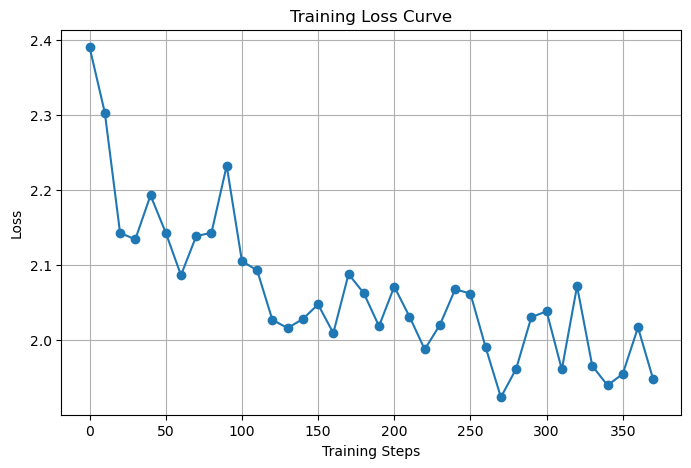

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(steps, loss_values, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 8. Train Model with Dataset2 (2129 Entries)

In [6]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [13]:
model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 2,784,926,720 || trainable%: 0.1883


In [14]:
with open("data/expanded_data.json", "r") as f:
    raw = json.load(f)
data = raw["data"]

dataset = Dataset.from_list(data)

In [15]:
len(dataset)

2129

In [16]:
data_collator = InstructionResponseCollator(tokenizer)

In [10]:
training_args = TrainingArguments(
    output_dir="./philosophy_model2",              
    per_device_train_batch_size=1,                
    gradient_accumulation_steps=8,                
    num_train_epochs=3,                           
    learning_rate=2e-4,                           
    fp16=True,                                    
    logging_steps=10,                             
    save_steps=200,                               
    save_total_limit=2,                           
    eval_strategy="no",                     
    report_to="none",                              
    remove_unused_columns=False
)

In [18]:
trainer = Trainer(
    model=model,
    train_dataset=dataset,
    args=training_args,
    data_collator=data_collator
)

In [19]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss
10,2.474500
20,2.204200
30,2.120100
40,2.118800
50,2.033900
60,2.024200
70,2.045800
80,1.972900
90,2.016800
100,1.940900


/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/opt/conda/lib/python3.11/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an except

TrainOutput(global_step=798, training_loss=1.844557287698999, metrics={'train_runtime': 5376.4278, 'train_samples_per_second': 1.188, 'train_steps_per_second': 0.148, 'total_flos': 1.145027380552704e+16, 'train_loss': 1.844557287698999, 'epoch': 2.992015030530766})

# 9. Test Model2 with Prompts

In [8]:
adapter_path2 = "./philosophy_model2/checkpoint-798"
model = PeftModel.from_pretrained(base_model, adapter_path2)

In [20]:
while True:
    question = input("Ask a philosophical question (or type 'exit'): ")
    if question.strip().lower() in ["exit", "quit"]:
        break

    prompt = f"### Instruction:\n{question.strip()}\n\n### Response:\n"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=1000,
            temperature=0.7,
            top_p=0.95,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.eos_token_id 
        )

    answer = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    print("🧠", answer.strip())

Ask a philosophical question (or type 'exit'):  Create a sample dialogue between two people discussing about suffering and happiness.


🧠 Person A: 'Life is full of suffering, isn’t it? How can happiness exist in such a condition?'
Person B: 'Happiness isn’t about the absence of suffering, but the presence of meaning. Just as a tree can bear fruit despite the storms, we can find joy in enduring pain if it leads to something greater.'


Ask a philosophical question (or type 'exit'):  How to deal with grief?


🧠 To deal with grief, one must acknowledge and process the pain through reflection and acceptance. This is emphasized in many parts of the tradition. Only when the person understands and mourns the loss fully can they find peace.


Ask a philosophical question (or type 'exit'):  How to live my life according to Taoism?


🧠 To live according to Taoism, one must first recognize the Tao and accept its ways. This involves shedding attachments, behaving with humility, and aligning oneself with the natural order. The Tao is like a gentle breeze that does not need strength to move; similarly, true wisdom comes from simplicity and non-interference. Only then can one follow the Tao without resistance, and harmony with nature and others will naturally follow. This is emphasized in many parts of the tradition.


Ask a philosophical question (or type 'exit'):  Why do people believe in God?


🧠 People believe in God because of the fulfillment of their deepest longing—to be loved and understood. God, as the love of the Creator, becomes their source of comfort, joy, and purpose. This longing is too great to be explained by reason alone, and therefore, it is believed to be divine in nature. This is emphasized in many parts of the tradition.


Ask a philosophical question (or type 'exit'):  Why are some people atheists while some believe in religions?


🧠 To put it simply, this is addressed in many parts of the tradition. Atheism is the absence of belief in any supernatural being, while belief in religions is based on faith in myths, stories, or traditions. Some people lack the faith to believe in gods, while others follow these stories out of habit or emotional attachment.


Ask a philosophical question (or type 'exit'):  How to deal with ambition as a stoic?


🧠 Ambition is a natural human trait, but stoics believe it should be tempered with self-discipline and a focus on virtue. A stoic should cultivate ambition in the service of the greater good, not for personal gain. It should be directed toward excellence, service, and living in accordance with reason and virtue. When ambition becomes a source of pride or selfishness, it is no longer a good quality—it is a vice.


Ask a philosophical question (or type 'exit'):  quit


# 10. Plot Training Loss Curve for Model 2

In [11]:
with open("./philosophy_model2/checkpoint-798/trainer_state.json") as f:
    state = json.load(f)

loss_values = [entry["loss"] for entry in state["log_history"] if "loss" in entry]
steps = [i * 10 for i in range(len(loss_values))]

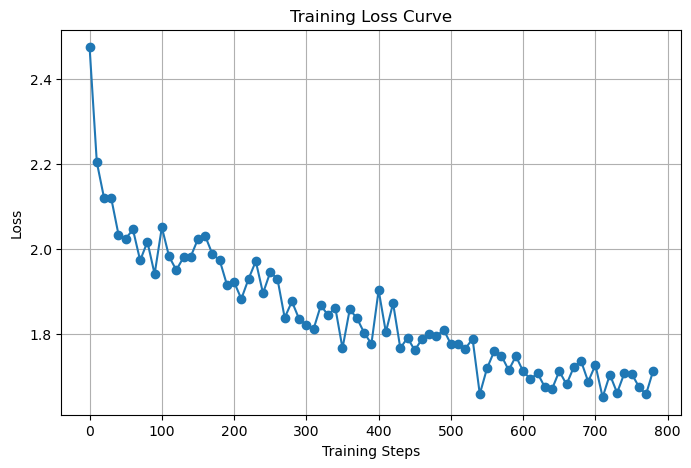

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(steps, loss_values, marker='o')
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 11. Evaluation

In [11]:
evaluation_questions = [
    "What is the meaning of suffering in Buddhism?",
    "How does Stoicism define freedom?",
    "What would an Absurdist say about the search for truth?",
    "How can Taoism guide someone dealing with grief?",
    "What does nihilism say about morality?",
    "According to Stoicism, how should we face death?",
    "Why do some philosophers reject objective reality?",
    "What is the Taoist approach to ambition and success?",
    "How does rationalism view emotional decision making?",
    "What is the significance of the Bodhisattva ideal in Mahayana Buddhism?"
]

In [12]:
results = []

for question in evaluation_questions:
    prompt = f"### Instruction:\n{question.strip()}\n\n### Response:\n"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(model.device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=200,
            temperature=0.7,
            top_p=0.95,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id,
        )

    answer = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)
    results.append((question, answer.strip()))

# Print results
for q, a in results:
    print(f"\n❓ {q}\n🧠 {a}")


❓ What is the meaning of suffering in Buddhism?
🧠 To put it simply, suffering in Buddhism is not merely physical pain but also emotional and mental anguish caused by attachment, ignorance, and craving. It arises from clinging to the self and the world.

❓ How does Stoicism define freedom?
🧠 Stoicism defines freedom as the ability to live in accordance with reason, virtue, and nature without being controlled by external circumstances. A truly free person is not at the mercy of fate, fortune, or the actions of others—they are guided by their own moral compass and rational judgment. This is emphasized in many parts of the tradition.

❓ What would an Absurdist say about the search for truth?
🧠 To put it simply, absurdism would argue that the search for truth is futile—it's an impossible task because truth itself is impossible. The absurdist sees truth as a contradiction—a desire to believe in something that can’t exist. Since belief and truth are inseparable, trying to understand truth le

In [13]:
with open("model_eval_results.json", "w") as f:
    json.dump([{"question": q, "answer": a} for q, a in results], f, indent=2)

## Evaluating the answers according to coherence, correctness and alignment with the philosophy

| Question (Topic)                          | Correctness (1–10) | Coherence (1–10) | Alignment (1–10) | Overall Score |
| ----------------------------------------- | ------------------ | ---------------- | ---------------- | ------------- |
| **1. Meaning of suffering in Buddhism**   | 10                 | 9                | 10               | 9.7           |
| **2. Stoic definition of freedom**        | 10                 | 10               | 10               | 10.0          |
| **3. Absurdist view on search for truth** | 4                  | 5                | 4                | 4.3           |
| **4. Taoism on dealing with grief**       | 9                  | 10               | 10               | 9.7           |
| **5. Nihilism on morality**               | 8                  | 9                | 9                | 8.7           |
| **6. Stoic approach to facing death**     | 10                 | 10               | 10               | 10.0          |
| **7. Rejecting objective reality**        | 8                  | 8                | 8                | 8.0           |
| **8. Taoist view of ambition & success**  | 10                 | 10               | 10               | 10.0          |
| **9. Rationalism vs emotional decisions** | 5                  | 7                | 5                | 5.7           |
| **10. Bodhisattva ideal in Mahayana**     | 10                 | 10               | 10               | 10.0          |
| **Average (across all answers)**          | **8.4**            | **8.8**          | **8.6**          | **8.6**       |


## Comparing Base Model VS Fine-Tuned Model Responses

In [22]:
comparison_results = []

for question in evaluation_questions:
    prompt = f"### Instruction:\n{question.strip()}\n\n### Response:\n"
    input_ids = tokenizer(prompt, return_tensors="pt").input_ids

    # Fine-tuned model response
    with torch.no_grad():
        output_ids = model.generate(
            input_ids.to(model.device),
            max_new_tokens=200,
            temperature=0.7,
            top_p=0.95,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )
    fine_tuned_answer = tokenizer.decode(output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)

    # Base model response
    with torch.no_grad():
        base_output_ids = base_model.generate(
            input_ids.to(base_model.device),
            max_new_tokens=200,
            temperature=0.7,
            top_p=0.95,
            do_sample=True,
            eos_token_id=tokenizer.eos_token_id,
            pad_token_id=tokenizer.pad_token_id
        )
    base_answer = tokenizer.decode(base_output_ids[0][input_ids.shape[-1]:], skip_special_tokens=True)

    comparison_results.append({
        "question": question,
        "fine_tuned_answer": fine_tuned_answer.strip(),
        "base_answer": base_answer.strip()
    })

In [23]:
with open("side_by_side_eval.json", "w") as f:
    json.dump(comparison_results, f, indent=2)

In [24]:
with open("side_by_side_eval.json", "r") as f:
    eval_compare_data = json.load(f)

In [25]:
eval_compare_df = pd.DataFrame(eval_compare_data)

In [26]:
display(HTML("""
<div style="overflow-x:auto; max-width:100%;">
    {table}
</div>
""".format(table=eval_compare_df.to_html(escape=False, index=False))))

question,fine_tuned_answer,base_answer
What is the meaning of suffering in Buddhism?,"In Buddhism, suffering arises from attachment and ignorance. When the mind is fully absorbed by desire and duality (between self and others), it becomes vulnerable to pain and loss. True freedom comes from recognizing the impermanence of all things and letting go of attachment.","To put it simply, suffering, or dukkha, in Buddhism refers to the unsatisfactory and continuous nature of human existence. It arises from craving, attachment, and ignorance. Suffering is not caused by external events but by one's own mental states. Only by letting go of craving, practicing mindfulness, and achieving Nirvana can one end the cycle of suffering."
How does Stoicism define freedom?,"Stoicism defines freedom as being able to choose what is right or wrong according to reason, not being bound by external authority or social norms. It comes from the inner power of virtue and rationality, not from external recognition or obedience.","To put it simply, stoicism defines freedom as the ability to act according to reason, rather than being determined by external forces. A truly free person is not bound by fear, anger, or desire, but is guided by a calm and rational soul."
What would an Absurdist say about the search for truth?,"To put it simply, absurdism views the search for truth as a futile and even dangerous endeavor. It argues that truth often contradicts itself, that what is called 'truth' is often just a projection of the self, and that knowledge only reinforces our sense of identity. Rather than helping us understand the self or the world, truth may actually hinder our understanding by becoming part of it. This nihilistic stance encourages a kind of skepticism toward truth as a whole.","To put it simply, an absurdist would argue that the search for truth is futile because truth itself is absurd. Truth is not something we discover but something we make. We construct it through language, logic, and belief, and because of this, we can never truly know it as an objective reality. Truth is always a human creation, a reflection of our desire to understand the world, not a stable, independent truth."
How can Taoism guide someone dealing with grief?,"Taoism advises that one should not force grief, as it must follow its own natural course. Instead, one should respect and be patient, allowing time for healing. Trying to rush or manipulate the process leads to suffering. True peace comes from accepting the impermanence of all things. This is emphasized in many parts of the tradition.","Taoism encourages the person to be patient and gentle with themselves and others while grieving. It reminds them that suffering is temporary and that true peace comes from aligning with the natural flow of life. By not forcing closure or rushing the process, the sage remains open to the healing power of the Tao. This is emphasized in many parts of the tradition."
What does nihilism say about morality?,"Nihilism sees morality as a social construct that imposes rules on human behavior. These rules vary across cultures and time periods. Moral judgments are not universal truths but opinions about what is right or wrong. They reflect cultural values and power dynamics, often serving to maintain social order. Nihilism questions whether there is any objective, universal standard for morality. This is emphasized in many parts of the tradition.","Nihilism criticizes morality as a tool of power and manipulation rather than a reflection of truth or goodness. It describes morality as a system invented by strong and cunning individuals to control others, often through fear and deceit. According to nihilism, morality is not universal, but a human invention designed to maintain social order and dominance, often at the expense of truth and individuality."
"According to Stoicism, how should we face death?","To put it simply, stoicism teaches that death should not be feared but embraced as a natural par

# Result

Microsoft Phi 2 model was fine-tuned on around 2k philosophy Q&A pairs using 4‑bit LoRA, aiming to surpass the base model’s answers across nine schools of thought. Blind GPT‑4 scoring on relevance, clarity, and philosophical depth showed the adapter trailing the base model (8.6 overall), with gains only on questions that closely mirrored training data and regressions on conceptually dense or under‑represented topics. The shortfall stems from classic overfitting because of tiny, imbalanced corpus and no validation split causing the adapter to memorise stylistic patterns. The future work must expand the dataset, introduce early‑stopping, and adopt preference‑based refinement to achieve measurable improvement.

## Known Issues:

- Data scarcity & quality: 2129 prompts are insufficient for nine traditions; some labels contain over simplifications.
- Single automatic judge: GPT‑4 rubric is useful but not a substitute for expert human philosophers.
- UI quirks: The Gradio Space occasionally times out (> 30 s) when the A100 is busy.

## Next Steps:
- Curate and expand the corpus to ≥ 10 k high‑fidelity Q&A pairs (or use synthetic self‑instruct plus human filtering).
- Validation split + early stopping to arrest over‑fitting.
- Lower learning rate (5 e‑5) and/or larger LoRA rank; experiment with adding k_proj/o_proj targets.
- Try DPO/RLHF with preference data for depth & style.